In [1]:
import pandas as pd
import numpy as np

In [12]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            # put it all together
            agg = concat(cols, axis=1)
            agg.columns = names
            # drop rows with NaN values
            if dropnan:
                agg.dropna(inplace=True)
        return agg

In [6]:
dataset = pd.read_csv("/Users/brandonbryant/Downloads/Bittrex10-9_10-16.csv")
dataset = dataset[dataset.MarketName == 'BTC-ETH']
dataset.TimeStamp = pd.to_datetime(dataset.TimeStamp, box=True)
dataset = dataset.sort_values(['TimeStamp'], ascending=True)
dataset = dataset.drop(['Unnamed: 0', 'Unnamed: 0.1', 'TimeStamp','MarketName', 'Created'], axis = 1)


In [7]:
dataset.columns

Index(['Ask', 'BaseVolume', 'Bid', 'High', 'Last', 'Low', 'OpenBuyOrders',
       'OpenSellOrders', 'PrevDay', 'Volume'],
      dtype='object')

In [8]:
values = dataset.values

In [9]:
values.shape

(355, 10)

In [10]:
values = values.astype('float32')

In [13]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [14]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.988124   0.147221   1.000000   1.000000   0.987391   1.000000   
2   1.000000   0.147095   0.997286   1.000000   1.000000   1.000000   
3   0.980684   0.144523   0.986284   0.996786   0.980964   1.000000   
4   0.860946   0.167194   0.868547   0.957578   0.862967   0.929497   
5   0.862034   0.189512   0.868449   0.957568   0.857498   0.880666   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.497603   0.177051   0.993298    0.105212  1.000000  0.147095  0.997286   
2   0.502832   0.215694   0.992195    0.105119  0.980684  0.144523  0.986284   
3   0.492375   0.239748   1.000000    0.103105  0.860946  0.167194  0.868547   
4   0.309804   0.329258   0.990992    0.123839  0.862034  0.189512  0.868449   
5   0.307625   0.299685   0.966969    0.144809  0.853333  0.185217  0.866062   

    var4(t)   var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  
1  1.000000  1.000

In [16]:
# split into train and test sets
values = reframed.values
n_train_hours = 284
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(284, 1, 19) (284,) (70, 1, 19) (70,)


In [18]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [19]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 284 samples, validate on 70 samples
Epoch 1/50
1s - loss: 0.3856 - val_loss: 0.1748
Epoch 2/50
0s - loss: 0.3048 - val_loss: 0.0984
Epoch 3/50
0s - loss: 0.2653 - val_loss: 0.0773
Epoch 4/50
0s - loss: 0.2461 - val_loss: 0.0815
Epoch 5/50
0s - loss: 0.2359 - val_loss: 0.0889
Epoch 6/50
0s - loss: 0.2291 - val_loss: 0.0951
Epoch 7/50
0s - loss: 0.2245 - val_loss: 0.0983
Epoch 8/50
0s - loss: 0.2211 - val_loss: 0.0972
Epoch 9/50
0s - loss: 0.2144 - val_loss: 0.0933
Epoch 10/50
0s - loss: 0.2060 - val_loss: 0.0896
Epoch 11/50
0s - loss: 0.1988 - val_loss: 0.0866
Epoch 12/50
0s - loss: 0.1917 - val_loss: 0.0842
Epoch 13/50
0s - loss: 0.1845 - val_loss: 0.0824
Epoch 14/50
0s - loss: 0.1771 - val_loss: 0.0810
Epoch 15/50
0s - loss: 0.1695 - val_loss: 0.0797
Epoch 16/50
0s - loss: 0.1617 - val_loss: 0.0786
Epoch 17/50
0s - loss: 0.1536 - val_loss: 0.0773
Epoch 18/50
0s - loss: 0.1452 - val_loss: 0.0757
Epoch 19/50
0s - loss: 0.1363 - val_loss: 0.0739
Epoch 20/50
0s - loss: 0.1271 - v

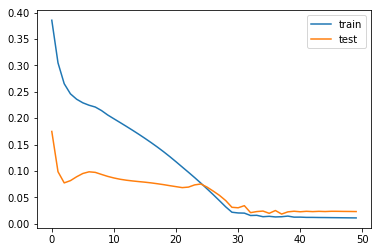

In [20]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

ValueError: Error when checking : expected lstm_1_input to have 3 dimensions, but got array with shape (70, 19)

In [24]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

ValueError: operands could not be broadcast together with shapes (70,19) (10,) (70,19) 

In [25]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: operands could not be broadcast together with shapes (70,19) (10,) (70,19) 

In [26]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.006
